# Uganda Agriculture Zero-Infated Poisson analysis 

<font color='red'>Note: </font> This analysis does not hold up for the agriculture observations because they are presence/absence counts.

### Data wrangling

The first step is to import the various python packages needed to conduct the analysis:

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gammaf
from scipy.misc import factorial as ft
import seaborn as sns
#from mpl_toolkits.basemap import Basemap as bm
import pymc as pm

Because arrays are more efficient than loops, we'll need a couple of functions to do some array indexing in the BHM. These are defined by the `def` statement in Python:

In [2]:
# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

The next step is to import the data:

In [3]:
# Import test dataset
xdata = pd.read_csv('uganda.csv')
xdata.head()

,cell_id,transect_id,natpark_in_out,survey_id,country_id,zebra_count,zebra_observations,livestock_count,livestock_observations,buffalo_count,buffalo_observations,agriculture_count,agriculture_observations,humanresources_count,humanresources_observations
0,35339,5852,0,833,17,0,0,0,0,0,0,0,0,0,0
1,35340,5852,0,833,17,0,0,0,0,0,0,0,0,0,0
2,35341,5852,1,833,17,0,0,0,0,0,0,0,0,0,0
3,35342,5852,1,833,17,0,0,0,0,0,0,0,0,0,0
4,35343,5852,1,833,17,0,0,0,0,0,0,0,0,0,0


In [4]:
xdata.columns.values

array(['cell_id', 'transect_id', 'natpark_in_out', 'survey_id',
       'country_id', 'zebra_count', 'zebra_observations',
       'livestock_count', 'livestock_observations', 'buffalo_count',
       'buffalo_observations', 'agriculture_count',
       'agriculture_observations', 'humanresources_count',
       'humanresources_observations'], dtype=object)

In [5]:
xdata.survey_id.unique()

array([833, 832])

In [6]:
xdata.transect_id.unique()

array([5852, 5851, 5850, 5849, 5848, 5847, 5846, 5845, 5844, 5843, 5842,
       5841, 5840, 5839, 5838, 5837, 5836, 5835, 5834, 5833, 5832, 5831,
       5830, 5829, 5828, 5827, 5826, 5825, 5824, 5823, 5822, 5821, 5820,
       5819, 5818, 5817, 5816, 5815, 5709, 5710, 5711, 5712, 5713, 5708,
       5715, 5686, 5687, 5688, 5689, 5707, 5685, 5691, 5692, 5734, 5690,
       5716, 5693, 5705, 5717, 5718, 5706, 5714, 5719, 5694, 5695, 5720,
       5696, 5697, 5721, 5698, 5699, 5700, 5701, 5703, 5704, 5722, 5702,
       5723, 5724, 5726, 5727, 5725, 5728, 5731, 5730, 5729, 5732, 5733])

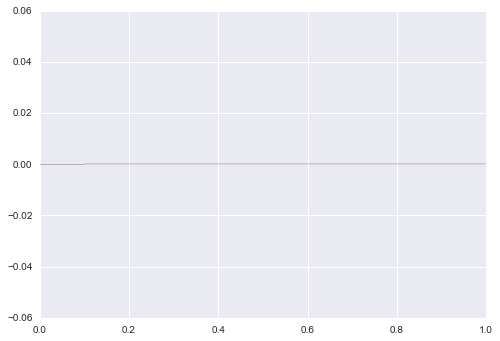

In [7]:
# Specify response - change here for other critters
response = xdata.agriculture_count.values

# Plot
plt.hist(response[response>0]);

In [8]:
# Observed zeros
Iz = (response==0)*1
# Observed counts
Ic = (response>0)*1

In [9]:
sum(Ic)/len(Ic)

0.0

In [10]:
# Create index to associate each cell with a given transect
Transect,It = indexall(xdata.transect_id.values)
ntrans = len(Transect)

# Use Python list indexing to create social-site indexing array
tindx = np.array([[x for x in It].index(i) for i in range(ntrans)])

# Indicator for being in/out of park
Park = xdata.natpark_in_out.values[tindx]

In [11]:
np.array(Transect)

array([5852, 5851, 5850, 5849, 5848, 5847, 5846, 5845, 5844, 5843, 5842,
       5841, 5840, 5839, 5838, 5837, 5836, 5835, 5834, 5833, 5832, 5831,
       5830, 5829, 5828, 5827, 5826, 5825, 5824, 5823, 5822, 5821, 5820,
       5819, 5818, 5817, 5816, 5815, 5709, 5710, 5711, 5712, 5713, 5708,
       5715, 5686, 5687, 5688, 5689, 5707, 5685, 5691, 5692, 5734, 5690,
       5716, 5693, 5705, 5717, 5718, 5706, 5714, 5719, 5694, 5695, 5720,
       5696, 5697, 5721, 5698, 5699, 5700, 5701, 5703, 5704, 5722, 5702,
       5723, 5724, 5726, 5727, 5725, 5728, 5731, 5730, 5729, 5732, 5733])

In [12]:
Park

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
# Create index to associate each transect with a given survey
Survey,Is = subindexall(xdata.survey_id.values,xdata.transect_id.values)
nsurvey = len(Survey)

In [14]:
Survey

[833, 832]

In [15]:
Is

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Bayesian hierarchical model

### Count model

In [16]:
# Global intercept
#gamma_0 = pm.Normal('global_mean', mu=0.0, tau=0.001, value=0.)

# Standard deviation of intercepts
#sigma1 = pm.Uniform('SD1', lower=0, upper=100, value=5.)
# Precisions of survey-scale intercepts
#tau1 = pm.Lambda('tau1', lambda sd=sigma1: sd**-2)

# Distribution of survey-scale intercepts
#eta_0 = pm.Normal('survey', mu=gamma_0, tau=tau1, value=np.ones(nsurvey))
eta_0 = pm.Normal('survey', mu=0.0, tau=0.001, value=np.ones(nsurvey))

# Standard deviation of transect-scale intercepts
sigma2 = pm.Uniform('SD2', lower=0, upper=100, value=1.)
# Precisions of transect-scale intercepts
tau2 = pm.Lambda('tau2', lambda sd=sigma2: sd**-2)

# Transect-scale intercepts
#beta_0 = pm.Normal('transect', mu=eta_0[Is], tau=tau2)

# Park effect
beta_1 = pm.Normal('park', mu=0.0, tau=0.001)

# Park model
mu = pm.Lambda('mu', lambda b0=eta_0[Is], b1=beta_1: b0+b1*Park)

# Transect-scale intercepts
beta_0 = pm.Normal('transect', mu=mu, tau=tau2)

# Link function for rate
lambduh = pm.Lambda('lambduh', lambda b=beta_0[It]: np.exp(b))

### Zeros model

In [17]:
# Global intercept
#gamma_0_z = pm.Normal('global_mean_z', mu=0.0, tau=0.001, value=0.)

# Standard deviation of intercepts
#sigma1_z = pm.Uniform('SD1_z', lower=0, upper=100, value=5.)
# Precisions of survey-scale intercepts
#tau1_z = pm.Lambda('tau1_z', lambda sd=sigma1_z: sd**-2)

# Distribution of survey-scale intercepts
#eta_0_z = pm.Normal('survey_z', mu=gamma_0_z, tau=tau1_z, value=np.ones(nsurvey))
eta_0_z = pm.Normal('survey_z', mu=0.0, tau=0.0001, value=np.ones(nsurvey))

# Standard deviation of transect-scale intercepts
sigma2_z = pm.Uniform('SD2_z', lower=0, upper=100, value=1.)
# Precisions of transect-scale intercepts
tau2_z = pm.Lambda('tau2_z', lambda sd=sigma2_z: sd**-2)

# Transect-scale intercepts
beta_0_z = pm.Normal('transect_z', mu=eta_0_z[Is], tau=tau2_z)


# Park effect
beta_1_z = pm.Normal('park_z', mu=0.0, tau=0.001)

# Park model
mu_z = pm.Lambda('mu_z', lambda b0=eta_0_z[Is], b1=beta_1_z: b0+b1*Park)

# Transect-scale intercepts
beta_0_z = pm.Normal('transect_z', mu=mu_z, tau=tau2_z)

# Zeros model
psi = pm.Lambda('psi', lambda b0=beta_0_z[It]: pm.invlogit(b0))

In [18]:
# ZINB likelihood
@pm.observed(dtype=int, plot=False)
def zinb(value=response, mu=lambduh, alpha=1., psi=psi):
    # Initialise likeihood
    like = 0.0
    # Add zero component; zero probability + P(NB==0); value flags for non-zeros to cancel out
    like += np.sum((np.log(psi + (1.-psi)*(alpha/(mu+alpha))**alpha))*Iz)
    # Add count component; non-zero probability + P(NB>0); value flags for zeros to cancel out
    like += np.sum((np.log(1.-psi) + np.log(gammaf(alpha+value))-np.log((ft(value)*gammaf(alpha))) + alpha*np.log(alpha/(mu+alpha)) + value*np.log(mu/(mu+alpha)))*Ic)
    return like

In [19]:
M = pm.MCMC(locals())
M.sample(100000, 99000)
M.sample(100000, 99000)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc-2.3.6-py3.5-macosx-10.6-intel.egg/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 100000 of 100000 complete in 65.0 sec

Plotting survey_0
Plotting survey_1


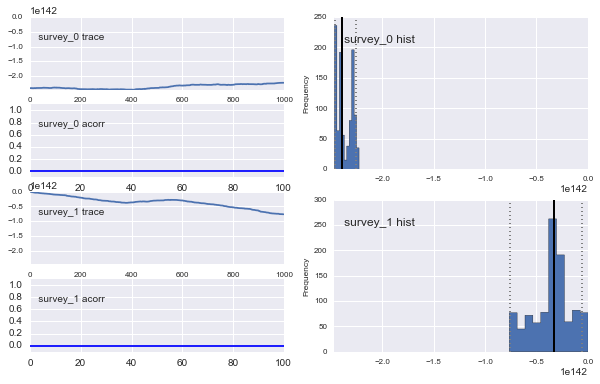

In [20]:
pm.Matplot.plot(M.eta_0)

In [21]:
[np.mean(x) for x in np.exp(M.eta_0.trace()).T]

[0.0, inf]

In [22]:
[np.percentile(x,2.5) for x in np.exp(M.eta_0.trace()).T]

[0.0, 0.0]

In [23]:
[np.percentile(x,97.5) for x in np.exp(M.eta_0.trace()).T]

[0.0, 0.0]

Plotting park


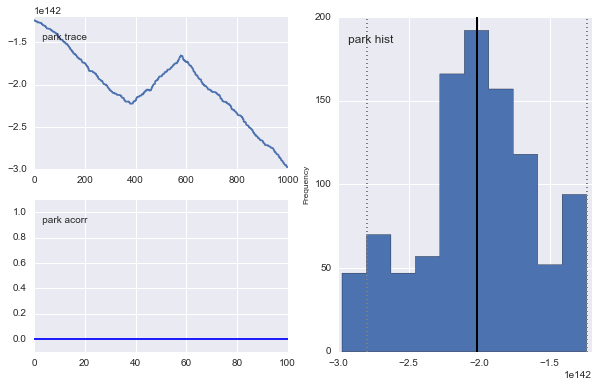

In [24]:
pm.Matplot.plot(M.beta_1)

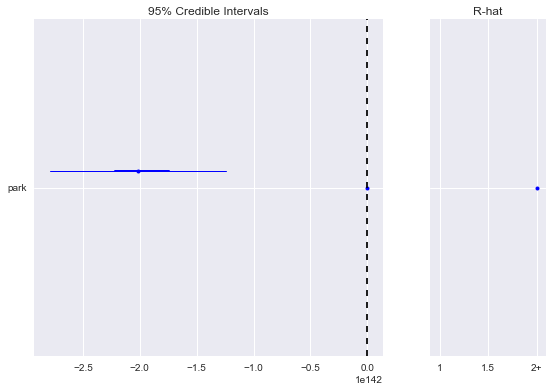

In [25]:
pm.Matplot.summary_plot(M.beta_1)

Plotting park_z


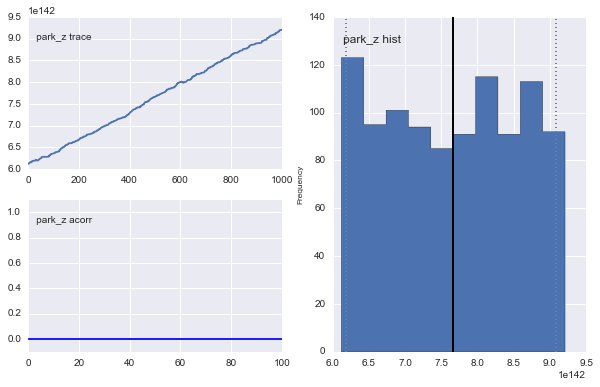

In [26]:
pm.Matplot.plot(M.beta_1_z)

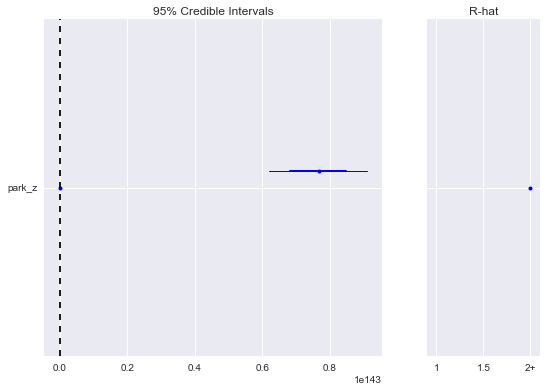

In [27]:
pm.Matplot.summary_plot(M.beta_1_z)

In [28]:
tmp = response[response>0]
tmp2 = xdata.natpark_in_out.values[response>0]

np.mean(tmp[tmp2==1])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


nan

In [29]:
np.mean(tmp[tmp2==0])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


nan